In [1]:
from app.core.config import settings
from app.database.milvus import get_milvus_client
get_milvus_client()


2024-12-30 13:02:04,886 - fastapi_project - INFO - Retrieved parameter: /tailorlink/mysql/MYSQL_URI
2024-12-30 13:02:05,104 - fastapi_project - INFO - Retrieved parameter: /tailorlink/mysql/MYSQL_USER
2024-12-30 13:02:05,296 - fastapi_project - INFO - Retrieved parameter: /tailorlink/mysql/MYSQL_PASSWORD
2024-12-30 13:02:05,489 - fastapi_project - INFO - Retrieved parameter: /tailorlink/mysql/MYSQL_DB_NAME
2024-12-30 13:02:05,682 - fastapi_project - INFO - Retrieved parameter: /tailorlink/openai/OPENAI_API_KEY
2024-12-30 13:02:05,882 - fastapi_project - INFO - Retrieved parameter: /tailorlink/milvus/MILVUS_URI
2024-12-30 13:02:06,116 - fastapi_project - INFO - Retrieved parameter: /tailorlink/milvus/MILVUS_TOKEN
2024-12-30 13:02:06,280 - fastapi_project - INFO - Retrieved parameter: /tailorlink/langchain/LANGCHAIN_API_KEY
2024-12-30 13:02:06,491 - fastapi_project - INFO - Retrieved parameter: /tailorlink/langchain/LANGCHAIN_ENDPOINT
2024-12-30 13:02:07,956 - fastapi_project - INFO - Co

In [2]:
from app.features.manual.nodes.rag_pipeline import run_manual_chatbot
res = run_manual_chatbot(user_input='에어컨 성능은?', car_id=1, history=['# 에어컨 작동법 에어컨을 작동시키려면, 먼저 차량의 시동을 켠 후, 대시보드에 있는 에어컨 버튼을 눌러 활성화합니다. 온도 조절 다이얼을 원하는 온도로 설정하고, 송풍 모드를 선택하여 공흐름을 조절할 수 있습니다. 에어컨의 성능을 최적화하기 위해 외부 공기 유입 모드와 내부 순환 모드를 적절히 조절하는 것이 좋습니다. 출처: 차량 매뉴얼 12페이지'])

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

2024-12-28 10:23:30,967 - fastapi_project - INFO - Running generate history base answer
2024-12-28 10:23:35,431 - fastapi_project - INFO - Running genesis check
2024-12-28 10:23:35,694 - fastapi_project - ERROR - Error in get_genesis_model: Database error: Textual SQL expression 'SELECT car_id, car_name F...' should be explicitly declared as text('SELECT car_id, car_name F...')


RuntimeError: Database error: Textual SQL expression 'SELECT car_id, car_name F...' should be explicitly declared as text('SELECT car_id, car_name F...')

In [9]:
print(res)

제네시스 차량 관련된 질문만 가능합니다.


In [2]:
from app.database.mysql import get_db_session
get_db_session()

2024-12-30 13:02:12,299 - fastapi_project - INFO - SQLAlchemy engine created successfully.


In [6]:
from app.features.manual.tools.tools import get_genesis_model
a = get_genesis_model()

2024-12-28 10:27:49,146 - fastapi_project - ERROR - Error in get_genesis_model: Database error: Textual SQL expression 'SELECT car_id, car_name F...' should be explicitly declared as text('SELECT car_id, car_name F...')


RuntimeError: Database error: Textual SQL expression 'SELECT car_id, car_name F...' should be explicitly declared as text('SELECT car_id, car_name F...')

In [4]:
from app.features.manual.models.model import create_openai_model
from app.features.manual.nodes.nodes import (
        generate_history_base_answer,
        genesis_check_and_query_split,
        generate_vector_search_base_answer,
        grade_hallucination,
        grade_hallucination_conditional,
        calculate_score,
        query_rewrite,
        history_base_answer_check_conditional,
        genesis_check_conditional,
        calculate_score_conditional
)
from langgraph.graph import StateGraph, START, END
from app.features.manual.utils.types import State

from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph


def run_manual_chatbot() :
    """
        RAG 파이프라인을 실행합니다.

        Args:
            user_input (str): 사용자 입력 질문.
            conversation_history (list): 이전 대화 기록 (선택적).

        Returns:
            str: RAG를 통해 생성된 최종 답변.
    """
    graph_builder = StateGraph(State)
    graph_builder.add_node("generate_history_base_answer", generate_history_base_answer)
    graph_builder.add_node("genesis_check", genesis_check_and_query_split)
    graph_builder.add_node("generate_vector_search_base_answer", generate_vector_search_base_answer)
    graph_builder.add_node("grade_hallucination", grade_hallucination)
    graph_builder.add_node("calculate_score", calculate_score)
    graph_builder.add_node("query_rewrite", query_rewrite)

    graph_builder.add_edge(START, "genesis_check")

    graph_builder.add_edge('query_rewrite', "generate_vector_search_base_answer")
    graph_builder.add_edge('generate_vector_search_base_answer', "grade_hallucination")
    graph_builder.add_edge('query_rewrite', "generate_vector_search_base_answer")

    graph_builder.add_conditional_edges(
        'generate_history_base_answer',
        history_base_answer_check_conditional,
        path_map={"search": "generate_vector_search_base_answer", END: END},
    )

    graph_builder.add_conditional_edges(
        'genesis_check',
        genesis_check_conditional,
        path_map={"write": "generate_history_base_answer", END: END},
    )

    graph_builder.add_conditional_edges(
        'grade_hallucination',
        grade_hallucination_conditional,
        path_map={"rewrite": "query_rewrite", 'calculate': "calculate_score"},
    )

    graph_builder.add_conditional_edges(
        "calculate_score",
        calculate_score_conditional,
        path_map={"rewrite": "query_rewrite", END: END},
    )
    graph = graph_builder.compile()


    return graph

graph = run_manual_chatbot()

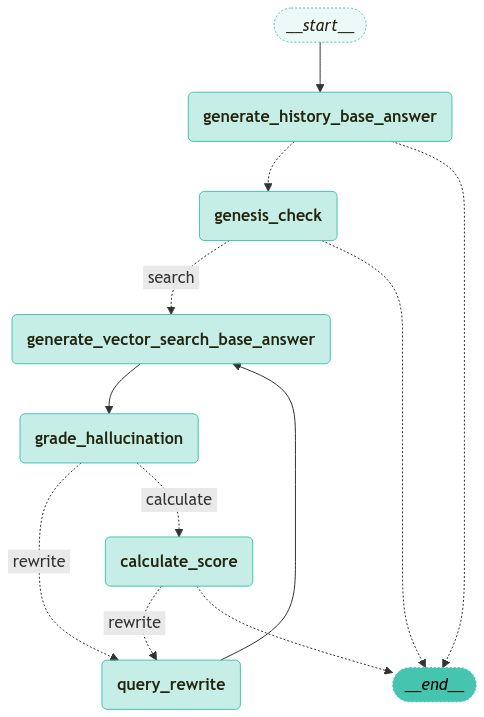

In [6]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)